In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Files already downloaded and verified
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


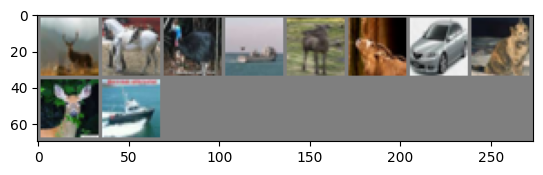

 deer horse  bird  ship  deer  deer automobile   cat  deer  ship


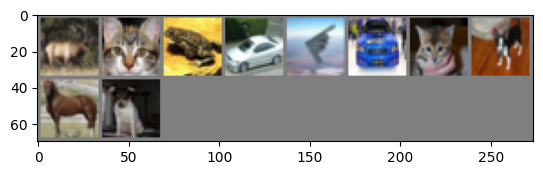

 deer   cat  frog automobile airplane automobile   cat   dog horse   dog


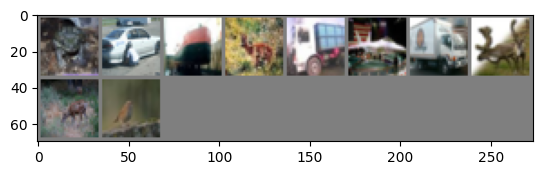

 frog automobile  ship  deer truck airplane truck  deer  deer  bird


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize
    img = np.clip(img, 0, 1)  # Clip to ensure pixel values are between 0 and 1
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Defining transformations to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image tensors
])

# Downloading and loading the training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Downloading and loading the test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Modified function to create a data loader for a subset of the dataset
def create_loader(dataset, num_classes, num_samples_per_class, batch_size, shuffle=True):
    class_counts = {i: 0 for i in range(num_classes)}
    subset_indices = []

    # Iterate through the dataset to collect indices of each class
    for idx, (_, label) in enumerate(dataset):
        if class_counts[label] < num_samples_per_class:
            subset_indices.append(idx)
            class_counts[label] += 1
            if all(count == num_samples_per_class for count in class_counts.values()):
                break

    subset = torch.utils.data.Subset(dataset, subset_indices)
    loader = torch.utils.data.DataLoader(subset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return loader

# Creating a data loader for the training dataset with batch sampling
train_loader = create_loader(train_dataset, num_classes=10, num_samples_per_class=500, batch_size=10, shuffle=True)
# Creating a data loader for the training dataset with batch sampling
test_loader = create_loader(test_dataset, num_classes=10, num_samples_per_class=100, batch_size=10, shuffle=False)

# The CIFAR-10 classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

num_batches_displayed = 0

# Getting some random training images
for images, labels in train_loader:

    # Showing images
    imshow(torchvision.utils.make_grid(images))

    # Printing labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(10)))
    num_batches_displayed = num_batches_displayed + 1

    if(num_batches_displayed == 3) :
      break
    else:
      continue

<h1>Feature Extraction : HoG

In [ ]:
# HoG features capture the shape and edge information.

import torch.nn as nn
import torchvision.models as models
from skimage.feature import hog
from skimage import exposure
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

# Function to compute HoG features
def compute_hog(img):
    # Resizing image
    resized_img = resize(img, (128*4, 64*4))
    # Creating HoG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd

# Initializing a list to store HoG features
hog_features_list = []


# Iterating through each batch of images and labels in the training loader
for images, _ in tqdm(train_loader):

    # Iterating through each image in the batch
    for img in images:
        # Computing HoG features for the image
        hog_features = compute_hog(img)
        # Appending the computed HoG features to the list
        hog_features_list.append(hog_features)


# Converting the list of HoG features to a numpy array
hog_features_array = np.stack(hog_features_list)

print("Shape of HoG features:", hog_features_array.shape)
print(hog_features_array)

# Saving the extracted HoG features
torch.save(hog_features_array, 'hog_features.pt')

100%|██████████| 500/500 [1:31:58<00:00, 11.04s/it]


Shape of HoG features: (5000, 70308)
[[0.3534874  0.         0.         ... 0.         0.         0.40118474]
 [0.40528557 0.         0.         ... 0.         0.         0.38267764]
 [0.40279588 0.         0.         ... 0.         0.         0.39047074]
 ...
 [0.34756958 0.07849407 0.         ... 0.         0.         0.3636428 ]
 [0.35354364 0.         0.         ... 0.         0.         0.32549798]
 [0.4180186  0.         0.         ... 0.         0.         0.30148748]]


<h1>Feature Extraction : CNN

In [ ]:
# CNN features capture higher-level visual semantics.

import torch.nn as nn
import torchvision.models as models
from PIL import Image
from tqdm import tqdm

# Loading pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

# Removing the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Setting the model to evaluation model
resnet.eval()

# Function to extract features from an image
def extract_features(image, model):
    # Preprocessing the image
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert tensor to PIL Image
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Adding batch dimension
    image = image.unsqueeze(0)
    # Extracting features
    with torch.no_grad():
        features = model(image)
    # Removing the batch dimension
    features = features.squeeze(0)
    return features

# Initializing a list to store CNN features
cnn_features_list = []

# Iterating through each image in the CIFAR-10 training dataset
for images, _ in tqdm(train_loader):

    for img in images:
        # Extracting CNN features for the image
        features = extract_features(img, resnet)
        # Appending the features to the list
        cnn_features_list.append(features)

# Converting the list of CNN features to a numpy array
cnn_features_array = torch.stack(cnn_features_list)

print("Shape of CNN features:", cnn_features_array.shape)
print(cnn_features_array)

# Saving the extracted CNN features
torch.save(cnn_features_array, 'cnn_features.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/500 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 500/500 [16:41<00:00,  2.00s/it]


Shape of CNN features: torch.Size([5000, 2048, 1, 1])
tensor([[[[0.3990]],

         [[0.7971]],

         [[0.3830]],

         ...,

         [[0.0508]],

         [[0.4841]],

         [[0.2946]]],


        [[[0.2888]],

         [[0.1442]],

         [[0.2377]],

         ...,

         [[0.1013]],

         [[0.1976]],

         [[0.0296]]],


        [[[0.0574]],

         [[0.8573]],

         [[0.4085]],

         ...,

         [[0.2339]],

         [[0.0014]],

         [[0.2865]]],


        ...,


        [[[0.3566]],

         [[0.5760]],

         [[0.3620]],

         ...,

         [[0.1041]],

         [[0.4789]],

         [[0.4519]]],


        [[[0.1354]],

         [[0.1426]],

         [[0.3312]],

         ...,

         [[0.0887]],

         [[0.7642]],

         [[0.6766]]],


        [[[0.2475]],

         [[0.1537]],

         [[0.3975]],

         ...,

         [[0.0594]],

         [[0.1412]],

         [[0.4103]]]])


<h1>Image retrieval using HoG Features by KNN

Query Image Label: frog


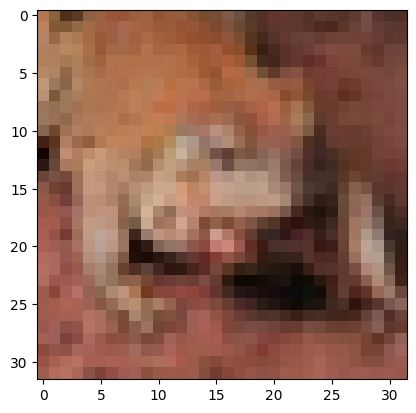

Similar Images to Query Image:
Label: frog


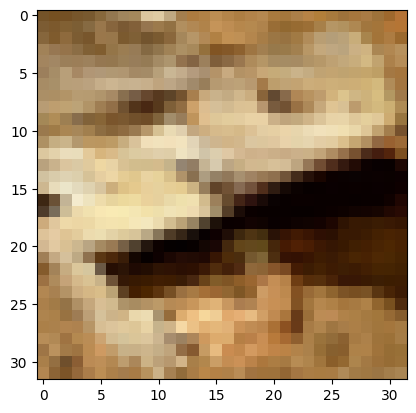

Label: automobile


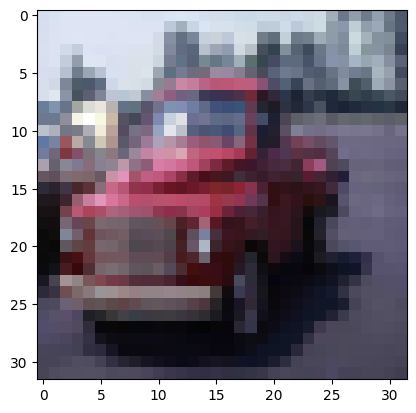

Label: truck


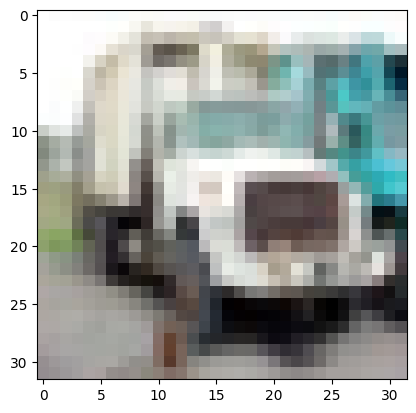

Label: horse


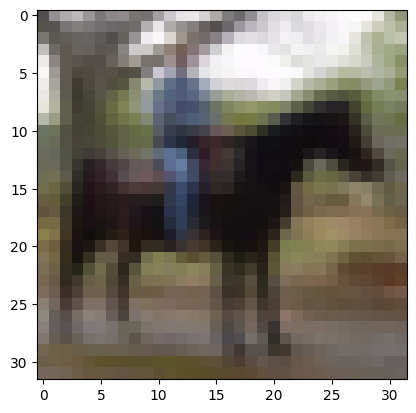

Label: truck


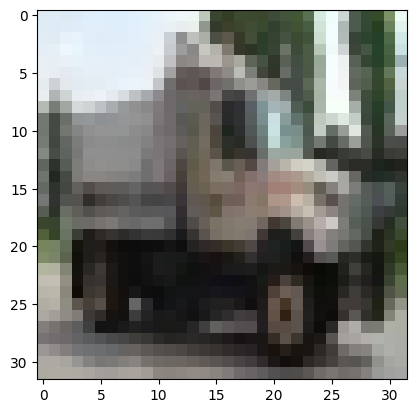

Label: frog


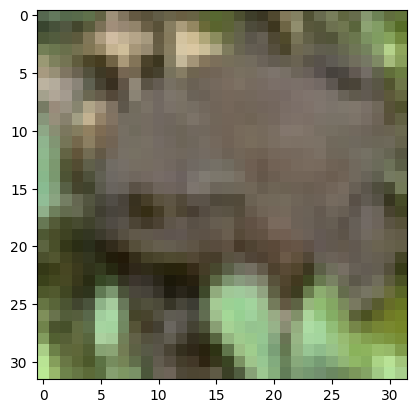

In [ ]:
from skimage.feature import hog
from skimage import exposure
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from skimage.transform import resize
import numpy as np

# Function to compute HoG features
def compute_hog(img):
    # Resizing image
    resized_img = resize(img, (128*4, 64*4))
    # Creating HoG features
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd

# Load and preprocess the query image
query_image, query_label = test_dataset[5]
print("Query Image Label:", classes[query_label])
imshow(query_image)

# Extract HOG features for the query image
query_features = compute_hog(query_image).reshape(1, -1)

hog_features_array = torch.load('/content/hog_features.pt')

hog_features_normalized = normalize(hog_features_array)

# Initialize the KNN model
knn_model = NearestNeighbors(n_neighbors=6, metric='cosine')

# Fit the KNN model with the normalized HOG features of the dataset
knn_model.fit(hog_features_normalized)

query_features_normalized = normalize(query_features)

# Find the indices of the k nearest neighbors for the query image
distances, k_most_similar_indices = knn_model.kneighbors(query_features_normalized)

# Display similar images with labels
print("Similar Images to Query Image:")
for idx in k_most_similar_indices[0]:
    similar_image, label = train_dataset[idx]  # Retrieve the similar image and its label from the dataset
    print("Label:", classes[label])
    imshow(similar_image)  # Display similar image

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Initialize lists to store predicted labels and ground truth labels
predicted_labels = []
ground_truth_labels = []

# Iterate over each batch in the test_loader
for images, labels in tqdm(test_loader):
    # Iterate over each image in the batch
    for query_image, query_label in zip(images, labels):
        # Extract HoG features for the query image
        query_features = compute_hog(query_image).reshape(1, -1)
        # Normalize the query features
        query_features_normalized = normalize(query_features)

        # Find the indices of the k nearest neighbors for the query image
        distances, k_most_similar_indices = knn_model.kneighbors(query_features_normalized)

        # Extract class labels of similar images and add to predicted_labels
        predicted_labels.extend([train_dataset[idx][1] for idx in k_most_similar_indices[0]])

        # Append the ground truth label to ground_truth_labels
        ground_truth_labels.extend([query_label.item()] * len(k_most_similar_indices[0]))

# Compute accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
print("Accuracy:", accuracy * 100, "%")


100%|██████████| 100/100 [42:55<00:00, 25.76s/it]

Accuracy: 10.183333333333334 %


<h1>Image retrieval using CNN Features by KNN

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Query Image Label: cat


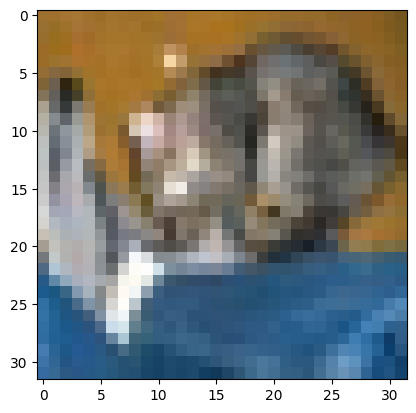

Similar Images to Query Image:
Label: deer


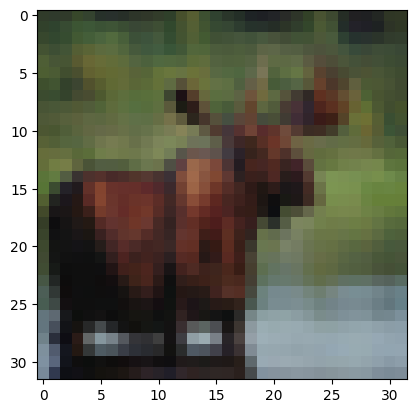

Label: horse


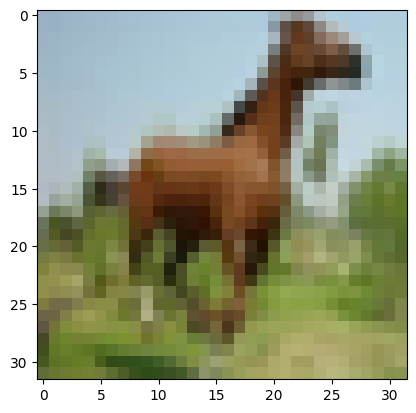

Label: dog


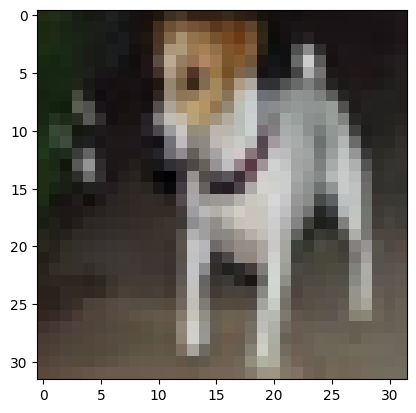

Label: cat


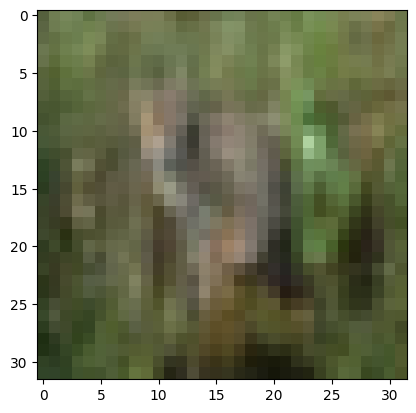

Label: cat


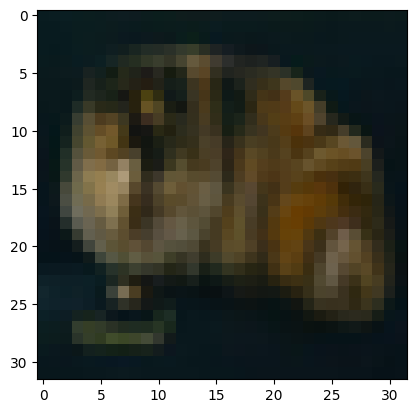

Label: horse


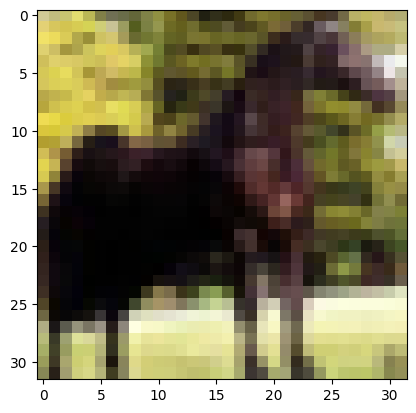

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import torch.nn as nn
import torchvision.models as models

# Loading pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)

# Removing the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])

# Setting the model to evaluation model
resnet.eval()

# Function to extract features from an image
def extract_features(image, model):
    # Preprocessing the image
    preprocess = transforms.Compose([
        transforms.ToPILImage(),  # Convert tensor to PIL Image
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    # Adding batch dimension
    image = image.unsqueeze(0)
    # Extracting features
    with torch.no_grad():
        features = model(image)
    # Removing the batch dimension
    features = features.squeeze(0)
    return features

# Load and preprocess the query image
query_image, query_label = test_dataset[0]
print("Query Image Label:", classes[query_label])
imshow(query_image)

query_features = extract_features(query_image, resnet).view(1, 2048)  # Extract features and reshape for similarity computation

cnn_features_array = torch.load('/content/cnn_features.pt')

# Reshape the CNN features array to 2D
cnn_features_array_2d = cnn_features_array.squeeze(-1).squeeze(-1)

# Normalize the CNN features array
normalized_cnn_features_array = cnn_features_array_2d / np.linalg.norm(cnn_features_array_2d, axis=1, keepdims=True)

# Initialize the KNN model
knn_model = NearestNeighbors(n_neighbors=6, metric='cosine')

# Fit the KNN model with the normalized CNN features of the dataset
knn_model.fit(normalized_cnn_features_array)

# Normalize the query features
normalized_query_features = query_features / np.linalg.norm(query_features)

# Find the indices of the k nearest neighbors for the query image
distances, k_most_similar_indices = knn_model.kneighbors(normalized_query_features)

# Display similar images with labels
print("Similar Images to Query Image:")
for i, idx in enumerate(k_most_similar_indices[0]):
    similar_image, label = train_dataset[idx]  # Retrieve the similar image and its label from the dataset
    print("Label:", classes[label])
    imshow(similar_image)  # Display similar image

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Initialize lists to store predicted labels and ground truth labels
predicted_labels = []
ground_truth_labels = []

# Iterate over each batch in the test_loader
for images, labels in tqdm(test_loader):
    # Iterate over each image in the batch
    for query_image, query_label in zip(images, labels):
        # Extract CNN features for the query image
        query_features = extract_features(query_image, resnet).view(1, 2048)
        # Normalize the query features
        query_features_normalized = normalize(query_features)

        # Find the indices of the k nearest neighbors for the query image
        distances, k_most_similar_indices = knn_model.kneighbors(query_features_normalized)

        # Extract class labels of similar images and add to predicted_labels
        predicted_labels.extend([train_dataset[idx][1] for idx in k_most_similar_indices[0]])

        # Append the ground truth label to ground_truth_labels
        ground_truth_labels.extend([query_label.item()] * len(k_most_similar_indices[0]))

# Compute accuracy
accuracy = accuracy_score(ground_truth_labels, predicted_labels)
print("Accuracy:", accuracy * 100, "%")

  0%|          | 0/100 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 100/100 [06:49<00:00,  4.09s/it]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 100/100 [06:50<00:00,  4.10s/it]

Accuracy: 10.549999999999999 %
